In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable GPU 
tf.config.experimental.set_visible_devices([], 'GPU')

%load_ext watermark
%watermark -v -iv

pandas           1.0.5
tensorflow_hub   0.9.0
autopep8         1.5.4
numpy            1.19.5
tensorflow       2.4.0
json             2.0.9
tensorflow.keras 2.4.0
CPython 3.7.4
IPython 7.8.0


## yoochoose-clicks.dat - Click events. Each record/line in the file has the following fields:
1. Session ID – the id of the session. In one session there are one or many clicks.
2. Timestamp – the time when the click occurred.
3. Item ID – the unique identifier of the item.
4. Category – the category of the item.

In [2]:
for chunk in pd.read_table("2019-Dec.csv",
                           sep=",", header=0,
                           infer_datetime_format=True, low_memory=False, chunksize=500000):
    # Filter out other event types than 'view'
    chunk = chunk[chunk['event_type'] == 'view']
    # Filter out missing 'category_code' rows
    chunk = chunk[chunk['category_code'].isna() == False]
    chunk.reset_index(drop=True, inplace=True)

    # Filter out all Sessions of length 1
    count_sessions = chunk.groupby('user_session').count()
    window_length = count_sessions.max()[0]
    unique_sessions = [count_sessions.index[i] for i in range(
        count_sessions.shape[0]) if count_sessions.iloc[i, 0] == 1]
    chunk = chunk[chunk['user_session'].isin(unique_sessions) == False]
    chunk.reset_index(drop=True, inplace=True)
    
    # Text embedding based on https://tfhub.dev/google/nnlm-en-dim50/2
    last_category = []
    for i, el in enumerate(chunk['category_code']):
        last_category.append(el.split('.')[-1])
    chunk['Product'] = last_category
    embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
    embeddings = embed(chunk['Product'].tolist())
    for dim in range(embeddings.shape[1]):
        chunk['embedding_'+str(dim)] = embeddings[:, dim]        
     
    # Create Item IDs starting from value 1 for Embeddings and One Hot Layer
    unique_items = pd.unique(chunk['product_id'])
    print('Number of unique Items:', unique_items.shape[0])
    dict_items = dict(zip(unique_items, [i+1 for i in range(unique_items.shape[0])]))
    chunk['product_id_mapped'] = chunk['product_id'].map(dict_items)
    d = pd.DataFrame.from_records(data=list(dict_items.items()), columns=['Item_ID', 'Mapped_ID'])
    # map product_id to category_code
    d['category_code'] = [chunk[chunk['product_id'] == i]['category_code'].values[0] for i in d['Item_ID']]
    d.to_csv('ID_Mapping.csv')

    # Standardization
    mean = chunk['price'].mean(axis=0)
    print('Mean:', mean)
    std = chunk['price'].std(axis=0)
    print('Std:', std)
    chunk['price_standardized'] = (chunk['price'] - mean) / std

    
    chunk.sort_values(by=['user_session', 'event_time'], inplace=True)
    chunk['price_standardized'] = chunk['price_standardized'].astype('float32')
    chunk['product_id_mapped'] = chunk['product_id_mapped'].astype('int32')
    chunk.reset_index(drop=True, inplace=True)
    
    
    print('Sessions:', pd.unique(chunk['user_session']).shape)
    print('Unique Products:',pd.unique(chunk['product_id']).shape)
    print('Unique category_code:',pd.unique(chunk['category_code']).shape)
    
    columns = ['embedding_'+str(i) for i in range(embeddings.shape[1])]
    columns.append('price_standardized')
    columns.append('user_session')
    columns.append('Product')
    columns.append('product_id_mapped')
    
    df = chunk[columns]
    break
df

Number of unique Items: 38515
Mean: 284.77105468660056
Std: 349.4674023158121
Sessions: (61296,)
Unique Products: (38515,)
Unique category_code: (134,)


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,price_standardized,user_session,Product,product_id_mapped
0,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.373028,0000afb3-2d30-4b52-84ec-07c6617efd37,light,27
1,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.373028,0000afb3-2d30-4b52-84ec-07c6617efd37,light,27
2,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,0.068930,0000b83c-9b26-4881-8bca-e20d460f4194,light,887
3,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,0.289895,0000b83c-9b26-4881-8bca-e20d460f4194,light,605
4,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.291904,0000f7c4-8836-4507-82a1-8a10de3fb1b2,light,1506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369299,0.174397,-0.204014,-0.175919,0.105906,-0.205940,-0.210022,0.224095,0.210598,-0.162613,0.150693,...,0.084346,0.071817,-0.129293,-0.176801,0.100340,0.119850,-0.630791,fffdfd5e-126c-409f-9c16-8224f22cb60b,cooler,7953
369300,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.511696,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,844
369301,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.511696,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,844
369302,0.047610,-0.125734,-0.053261,0.196848,-0.016433,0.049773,0.012852,0.263229,-0.195415,0.327227,...,0.106797,-0.214412,0.090539,0.104421,0.061444,-0.008996,-0.459760,fffe34dd-9537-4991-9f12-d81f1dda91cb,light,8


In [3]:
sessions_padded = np.load('list_sessions_padded_autoencoder.npy')
print(sessions_padded.shape)
n_output_features = int(sessions_padded.max())
n_unique_input_ids = int(sessions_padded.max())
window_length = sessions_padded.shape[1]
n_input_features = sessions_padded.shape[2]

(45916, 207, 1)


### LSTM Autoencoder in functional API
- Input: x rows (time steps) of Item IDs in a Session
- Output: reconstructed Session

In [4]:
def build_autoencoder(window_length=50,
                      units_lstm_layer=100,
                      n_unique_input_ids=0,
                      embedding_dim=200,
                      n_input_features=1,
                      n_output_features=3,
                      dropout_rate=0.1):

    inputs = keras.layers.Input(
        shape=[window_length, n_input_features], dtype=np.float32)

    # Encoder
    # Embedding Layer
    embedding_layer = tf.keras.layers.Embedding(
        n_unique_input_ids+1, embedding_dim, input_length=window_length)  # , mask_zero=True)
    embeddings = embedding_layer(inputs[:, :, 0])

    mask = inputs[:, :, 0] != 0

    # LSTM Layer 1
    lstm1_output, lstm1_state_h, lstm1_state_c = keras.layers.LSTM(units=units_lstm_layer, return_state=True,
                                                                   return_sequences=True)(embeddings, mask=mask)
    lstm1_state = [lstm1_state_h, lstm1_state_c]

    # Decoder
    # input: lstm1_state_c, lstm1_state_h
    decoder_state_c = lstm1_state_c
    decoder_state_h = lstm1_state_h
    decoder_outputs = tf.expand_dims(lstm1_state_h, 1)

    list_states = []
    decoder_layer = keras.layers.LSTM(
        units=units_lstm_layer, return_state=True, return_sequences=True, unroll=False)
    for i in range(window_length):
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_layer(decoder_outputs,
                                                                          initial_state=[decoder_state_h,
                                                                                         decoder_state_c])
        list_states.append(decoder_state_h)
    stacked = tf.stack(list_states, axis=1)

    fc_layer = tf.keras.layers.Dense(
        n_output_features+1, kernel_initializer='he_normal', dtype=tf.float32)

    fc_layer_output = tf.keras.layers.TimeDistributed(fc_layer)(
        stacked, mask=mask)

    mask_softmax = tf.tile(tf.expand_dims(mask, axis=2),
                           [1, 1, n_output_features+1])

    softmax = tf.keras.layers.Softmax(axis=2)(
        fc_layer_output, mask=mask_softmax)

    model = keras.models.Model(inputs=[inputs],
                               outputs=[softmax])
    return model

In [5]:
model = build_autoencoder(window_length=window_length,
                                             n_output_features=n_output_features,
                                             n_unique_input_ids=n_unique_input_ids,
                                             n_input_features=n_input_features,
                                             embedding_dim=200,
                                             units_lstm_layer=500,
                                             dropout_rate=0.0)
model.load_weights("weights")

In [6]:
id_mapping = pd.read_csv('ID_Mapping.csv')
distribution_items = df.groupby('product_id_mapped').count()

if os.path.isfile('errors.npy'):
    errors = np.load('errors.npy')
else:
    list_errors = []
    bce = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='sum')
    batch_size = 128

    try:
        for i in range(0, sessions_padded.shape[0], batch_size):
            print(i)
            y_pred = model(sessions_padded[i:i+batch_size])
            y_true = sessions_padded[i:i+batch_size]

            for batch in range(0, batch_size, 1):
                total = 0.0
                for j in range(sessions_padded.shape[1]):
                    if y_true[batch, j, 0] > 0:
                        loss = bce(y_true[batch, j, 0], y_pred[batch, j, :])
                        total = total + loss
                    else:
                        break
                list_errors.append(total.numpy())
    except Exception:
        errors = np.array(list_errors)
        np.save('errors.npy', errors)

0
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9088
9216
9344
9472
9600
9728
9856
9984
10112
10240
10368
10496
10624
10752
10880
11008
11136
11264
11392
11520
11648
11776
11904
12032
12160
12288
12416
12544
12672
12800
12928
13056
13184
13312
13440
13568
13696
13824
13952
14080
14208
14336
14464
14592
14720
14848
14976
15104
15232
15360
15488
15616
15744
15872
16000
16128
16256
16384
16512
16640
16768
16896
17024
17152
17280
17408
17536
17664
17792
17920
18048
18176
18304
18432
18560
18688
18816
18944
19072
19200
19328
19456
19584
19712
19840
19968
20096
20224
20352
20480
20608
20736
20864
20992
21120
21248
21376
21504
21632
21760
21888
22016
22144
22272
22400
22528
22656
22784
22912
23040
231

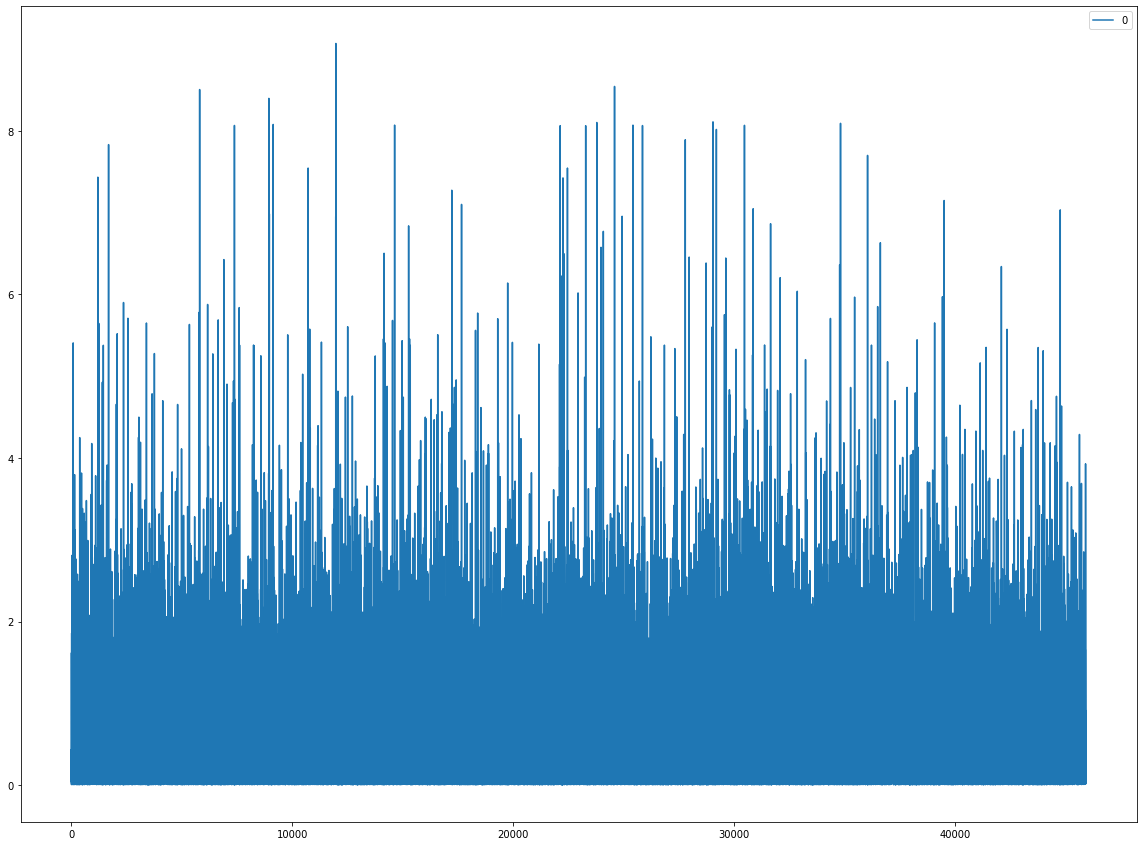

In [8]:
mask = sessions_padded[:, :, 0]!=0
lengths_session = mask.sum(axis=1)
mean_errors = errors/lengths_session
pd.DataFrame(mean_errors).plot(figsize=(20,15))

In [9]:
tmp = np.where(mean_errors>5)
tmp

(array([   85,  1202,  1242,  1449,  1687,  2079,  2363,  2563,  3400,
         3760,  5345,  5779,  5808,  6169,  6404,  6648,  6904,  7383,
         7600,  7615,  8248,  8278,  8578,  8940,  8963,  9137,  9794,
        10470, 10717, 10790, 11320, 11967, 11973, 12508, 13756, 14126,
        14155, 14195, 14537, 14632, 14975, 15266, 15308, 15340, 16583,
        17219, 17661, 18293, 18391, 19298, 19749, 19963, 21158, 22096,
        22128, 22195, 22252, 22298, 22454, 22934, 23279, 23782, 23973,
        24078, 24585, 24928, 25419, 25850, 26229, 26842, 27314, 27787,
        27962, 28716, 28728, 28995, 29041, 29194, 29560, 29620, 30082,
        30465, 30832, 30859, 31375, 31647, 32083, 32855, 33229, 34356,
        34773, 34783, 34812, 35450, 36036, 36213, 36493, 36615, 36941,
        38278, 39071, 39425, 39502, 41133, 41401, 42092, 42347, 43757,
        43985, 44757], dtype=int64),)

In [10]:
example = 23279 # 23279
session = pd.DataFrame()
session['category_code'] = [id_mapping['category_code'][int(i)-1] for i in sessions_padded[example,:,0] if i>0]
session['Item_ID'] = [id_mapping['Item_ID'][int(i)-1] for i in sessions_padded[example,:,0] if i>0]
session['Item_ID_Mapped'] = [int(i) for i in sessions_padded[example,:,0] if i>0]
session['Count'] = [distribution_items.loc[i, 'embedding_0'] for i in session['Item_ID_Mapped']]
#session.drop(['Item_ID_Mapped'], axis=1, inplace=True)
session

,category_code,Item_ID,Item_ID_Mapped,Count
0,construction.tools.light,1005105,87,1607
1,apparel.shoes.sandals,17300756,6761,18


# Custom Session

In [11]:
y_true = np.zeros((1, 207, 1), dtype=np.int32)
y_true[0,0,0] = 2499
y_true[0,1,0] = 29
y_true[0,2,0] = 100
y_true[0,3,0] = 1001 #1000
y_true[0,4,0] = 1507
y_true[0,5,0] = 501 #3000

In [13]:
list_errors = []
bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='sum')
batch_size = 1

for i in range(0, y_true.shape[0], batch_size):
    y_pred = model(y_true)
    
    for batch in range(0, batch_size, 1):
        total = 0.0
        for j in range(sessions_padded.shape[1]):
            if y_true[batch,j,0] > 0:
                loss = bce(y_true[batch,j,0], y_pred[batch,j,:])
                total = total + loss
            else:
                break
        list_errors.append(total.numpy())

errors_2 = np.array(list_errors)
mask = y_true[:, :, 0]!=0
lengths_session = mask.sum(axis=1)
mean_errors_2 = errors_2/lengths_session
mean_errors_2

array([6.36947505])

In [14]:
session = pd.DataFrame()
session['category_code'] = [id_mapping['category_code'][int(i)-1] for i in y_true[0,:,0] if i>0]
session['Item_ID'] = [id_mapping['Item_ID'][int(i)-1] for i in y_true[0,:,0] if i>0]
session['Item_ID_Mapped'] = [int(i) for i in y_true[0,:,0] if i>0]
session['Count'] = [distribution_items.loc[i, 'embedding_0'] for i in session['Item_ID_Mapped']]
#session.drop(['Item_ID_Mapped'], axis=1, inplace=True)
session

,category_code,Item_ID,Item_ID_Mapped,Count
0,electronics.audio.headphone,4804572,2499,280
1,furniture.living_room.chair,7203227,29,51
2,electronics.clocks,5100564,100,242
3,construction.tools.light,1004723,1001,188
4,apparel.costume,16500005,1507,96
5,computers.peripherals.printer,26400286,501,21
